# Harmonic Balance Method (HBM)

This jupyter notebook explores the inner workings of the **Harmonic Balance Method**. Special emphasis is given to the step of **Alternating Frequency-Time Sampling (AFT)**.

## Main Idea

Periodic movements occur in many technical systems, such as turbines, bearings, rotors and many others. The **Harmonic Balance Method** exploits this periodicity by representing the solution as a truncated Fourier series. The coefficients are determined in a Galerkin-like manner such that the governing equation is satisfied as closely as possible.

## 1. System Modeling

Let's have a look at a general case of a damped, forced, nonlinear system - in the literature called **Duffing Oscillator**.  
Imagine a block of a certain mass $m$. It is tied to a wall through a damper with coefficient $d$, a linear spring with stiffness $c$ and a rubber band (nonlinear spring) with stiffness $\alpha$. Now we periodically pull the block away from the wall with an external force described by $F_{\text{ex}} = F_0\sin(\Omega t)$. The situation is as follows:

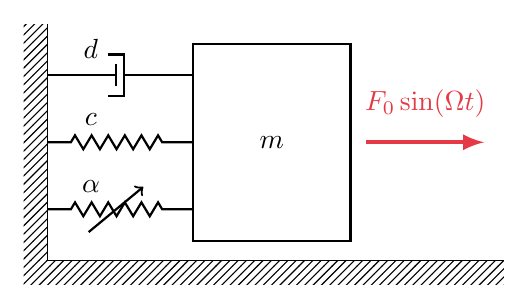

In [8]:
from pdf2image import convert_from_path
from IPython.display import display

pages = convert_from_path("../tex/Duffing_schematic.pdf")
display(pages[0])

What we would like to know is how the system responds to the actuation and how the mass moves. The movement is described by the displacement $q$ measured from the starting position. To find out about $q$, we need to model the system mathematically.  
As long as the system is not broken, all forces acting on the block are balanced: the further we pull the mass from the wall, the larger the opposing forces from the damper, the spring and the rubber band become. According to Newton, the sum of these forces (the damping force $d\dot{q}$, the spring force $cq$, the rubber band force $\alpha q^3$ and the external pulling force $F_{ex} = F_0 \sin(\Omega t)$) is equivalent to the mass's inertia $m\ddot{q}$:
$$m\ddot{q} = F_{\text{ex}} - (d \dot{q} + c q + \alpha q^3)$$
The rubber band adds the interesting part: the farther it is stretched, the stronger it resists. Mathematically speaking, it behaves nonlinearly, which makes the equation more difficult to solve.  

## 2. Fourier Ansatz

Since we pull with a periodic force, we can assume that the block will also move periodically.  
Periodic behavior can be very well approximated with a Fourier series
$$q(t) \approx \sum_{k=-H}^H \hat{q}_k e^{ik\Omega t} = \frac{a_0}{2} + \sum_{k=1}^H \Big(a_k \cos(k\Omega t) + b_k \sin(k\Omega t)\Big),$$
which is a combination of multiple harmonics with different frequencies and amplitudes. The complex-exponential representation on the left is equivalent to the cosine-sine representation on the right and the forms can straightforwardly be converted. The difference is that the complex form uses one complex coefficient $\hat{q}_k$ per harmonic $k \in [-H, H]$, while the cosine-sine form requires two real coefficients $a_k$ and $b_k$ for each $k \in [1, H]$. For real-valued time signals, the complex Fourier coefficients satisfy the Hermitian symmetry $\hat{q}_{-k}=\hat{q}^*_k$, so it would even be sufficient to store only the coefficients for $k \in [0,H]$.   
The cosine-sine form is useful for implementation when solution algorithms can only handle real-valued parameters (recall this for the code example at the end). The complex-exponential form, on the other hand, is more convenient and compact when deriving the equations in the following sections, so will we stick to that representation for now.

Different combinations of the complex coefficients $\hat{q}_k$ can model very different signals, for example the ones shown in the plot below.

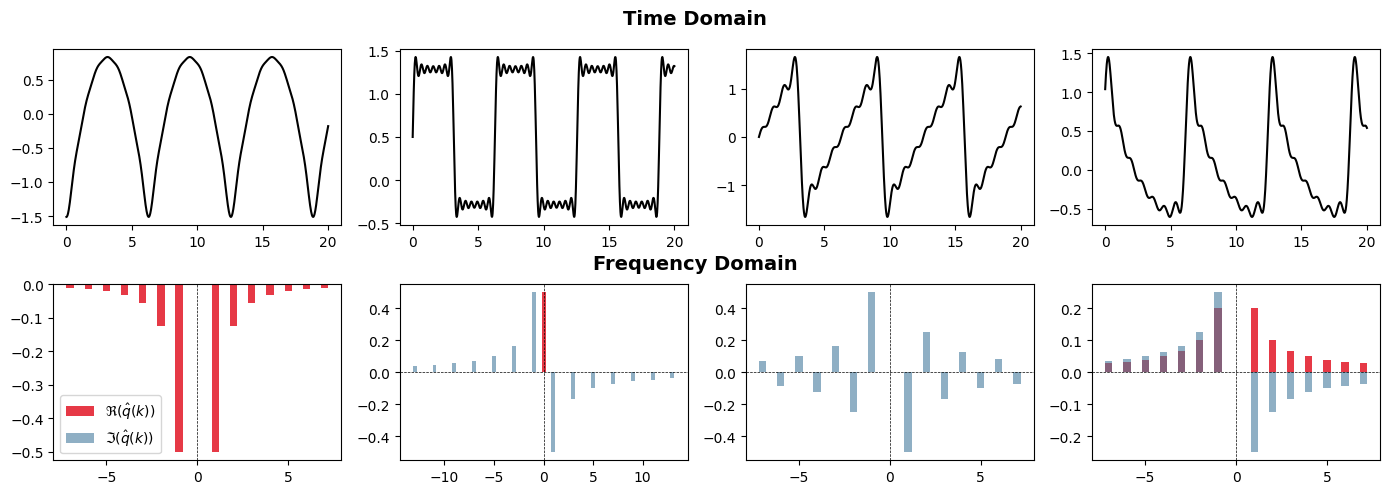

In [9]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,4,figsize=(14,5))
x = np.linspace(0, 20, 1000)

f_from_cn = lambda c,x: sum(c[n]*np.exp(1j*n*x) for n in c)
def plot_cn(ax, c, legend=False):
    ns, vals = zip(*sorted(c.items()))
    ax.bar(ns, np.real(vals), 0.4, color='#E63946', label=r'$\Re(\hat{q}(k))$')
    ax.bar(ns, np.imag(vals), 0.4, color='#457B9D', alpha=0.6, label=r'$\Im(\hat{q}(k))$')
    if legend: ax.legend()
    ax.axhline(0,color='k',lw=0.5,ls='--'); ax.axvline(0,color='k',lw=0.5,ls='--')

c1 = {n:-1/(2*n**2) for n in range(1,8)}
c1 |= {-n:v for n,v in c1.items()}
ax[0,0].plot(x, np.real(f_from_cn(c1,x)), 'k'); plot_cn(ax[1,0],c1, legend=True)

c2 = {0:0.5} | {n:-1j/(2*n) for n in range(1,14,2)}
c2 |= {-n:v.conjugate() for n,v in c2.items() if n>0}
ax[0,1].plot(x, np.real(f_from_cn(c2,x)), 'k'); plot_cn(ax[1,1],c2)

c3 = {n:(-1)**(n+1)/(2j*n) for n in range(1,8)}
c3 |= {-n:-v for n,v in c3.items()}
ax[0,2].plot(x, np.real(f_from_cn(c3,x)), 'k'); plot_cn(ax[1,2],c3)

c4 = {n:1/(5*n)-1j/(4*n) for n in range(1,8)}
c4 |= {-n:v.conjugate() for n,v in c4.items()}
ax[0,3].plot(x, np.real(f_from_cn(c4,x)), 'k'); plot_cn(ax[1,3],c4)

fig.text(0.5,0.95,'Time Domain',ha='center',fontsize=14,fontweight='bold')
fig.text(0.5,0.46,'Frequency Domain',ha='center',fontsize=14,fontweight='bold')
plt.tight_layout(h_pad=2.5); plt.subplots_adjust(top=0.9)
plt.show()


From the figure, we can see that the signals can be described either with rather complicated expressions over time $t$ or with the help of the Fourier coefficients $\hat{q}_k$. Both are exact and unambiguous descriptions of the same signal. For the leftmost example, the signal looks like this in time space
$$
q(t)
= \Re\!\Big(
-\frac{1}{2}\big(e^{i t} + e^{-i t}\big)
-\frac{1}{8}\big(e^{i 2 t} + e^{-i 2 t}\big)
-\frac{1}{18}\big(e^{i 3 t} + e^{-i 3 t}\big)
-\frac{1}{32}\big(e^{i 4 t} + e^{-i 4 t}\big)\\
-\frac{1}{50}\big(e^{i 5 t} + e^{-i 5 t}\big)
-\frac{1}{72}\big(e^{i 6 t} + e^{-i 6 t}\big)
-\frac{1}{98}\big(e^{i 7 t} + e^{-i 7 t}\big)
\Big),
$$
while in Fourier space, it is sufficient to save only the coefficient vector
$$
\left[-\frac{1}{98}, -\frac{1}{72}, -\frac{1}{50}, -\frac{1}{32}, -\frac{1}{18}, -\frac{1}{8}, -\frac{1}{2}, 0, -\frac{1}{2}, -\frac{1}{8}, -\frac{1}{18}, -\frac{1}{32}, -\frac{1}{50}, -\frac{1}{72}, -\frac{1}{98}\right]
$$
Since the latter is more convenient, we will mostly work in the Fourier space now instead of the time space.

We assume that our solution can be modeled by such an expression, so we will only need to find the right coefficient vector for a preset number of harmonics to make our solution fit the equation.  
**Caution:** The Fourier ansatz is only an approximation. It might not match the exact solution, but we can account for that by adjusting the coefficients. This is what we call the Galerkin method: we take a number of basis functions (here, Fourier terms) and determine their ansatz parameters (here the Fourier coefficients) so that the remaining error is distributed as evenly as possible.

## 3. Ansatz Insertion

Now that we have an idea of what our solution will look like overall (a Fourier series with still unknown coefficients), we can insert this ansatz into the equation and solve for these unknown coefficients. But for that, we first need the expressions of $\dot{q}$, $\ddot{q}$ and $q^3$.  
In Fourier space, the derivation of $\hat{q}$ is straightforward:
$$q(t) = \sum_k \hat{q}_k e^{i k \Omega t}$$
$$\dot{q}(t) = \sum_k (ik\Omega) \hat{q}_k e^{i k \Omega t}$$
$$\ddot{q}(t) = \sum_k -(k\Omega)^2 \hat{q}_k e^{i k \Omega t}$$

The nonlinearity $q^3$ however, needs special care - and this is where the **AFT** comes into play.

## 4. AFT (Alternating Frequency-Time)

Earlier, we decided to work in Fourier space because a lot of expressions (like those for the signal itself and for its derivatives) are much simpler there. However, for the nonlinearity this is not the case. In Fourier space, our cubic nonlinearity becomes a convolution 
$$\widehat{q^3}_k = \sum_{p=-H}^H\sum_{r=-H}^H \hat{q}_p \hat{q}_r \hat{q}_{k-p-r},$$
which means that each frequency component interacts with all the others. For each $k$, we would have to summarize all possible triplets $(p, r, k-p-r)$, whose frequencies add up to $k$, which scales with $\mathcal{O}(H^3)$.  
In time domain, on the other hand, exponentiation is local, and can be computed pointwise, scaling with $\mathcal{O}(H)$. Therefore, it is computationally advantageous to evaluate the nonlinearity in the time domain. We transform the displacement $\hat{q}_k$ from Fourier space to the time samples $q(t_n)$, compute the nonlinear force as $f_{\text{nl}}=q(t_n)^3$, and then transform it back to Fourier space to obtain $\hat{f}_{\text{nl}, k}$. Even considering the back-and-forth Fourier transformations, the whole process scales only with $\mathcal{O}(H\log H)$.

The figure below shows an example of this process.

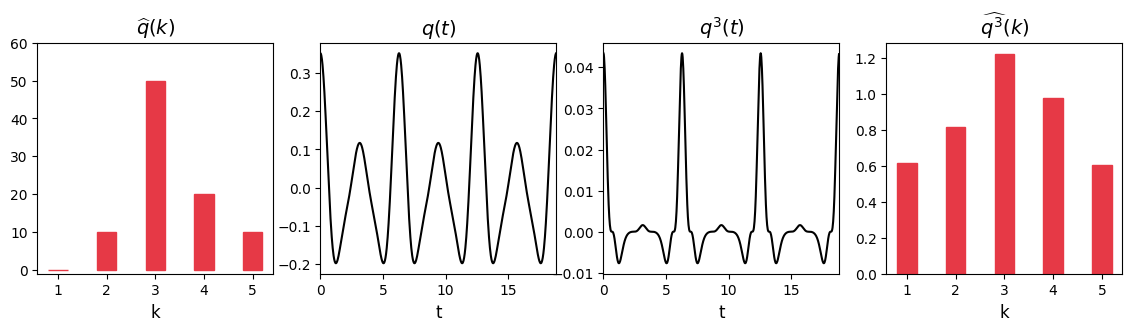

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,4,figsize=(14,3))
x = np.linspace(0, 20, 1000)

k = np.linspace(1, 5, 5)
q_F = [0, 10, 50, 20, 10]
ax[0].bar(k, np.real(q_F), 0.4, color='#E63946', edgecolor='#E63946')
ax[0].set_xlabel('k', fontsize=12)
ax[0].set_title(r'$\widehat{q}(k)$', fontsize=14,fontweight='bold')
ax[0].set_ylim(-1, 60)

N = 256
Q = np.zeros(N, dtype=complex)
for n, v in enumerate(q_F):
    Q[n % N] = v
q_T = np.fft.ifft(Q).real
t = np.linspace(0, 2*np.pi, N, endpoint=False)
ax[1].plot(np.concatenate([t, t+2*np.pi, t+4*np.pi]), np.tile(q_T, 3), 'k')
ax[1].set_xlabel('t', fontsize=12)
ax[1].set_xlim(0, 6*np.pi)
ax[1].set_title(r'$q(t)$', fontsize=14,fontweight='bold')

q3_T = q_T**3
ax[2].plot(np.concatenate([t, t+2*np.pi, t+4*np.pi]), np.tile(q3_T, 3), 'k')
ax[2].set_xlabel('t', fontsize=12)
ax[2].set_xlim(0, 6*np.pi)
ax[2].set_title(r'$q^3(t)$', fontsize=14,fontweight='bold')

q3_F = np.fft.fft(q3_T)
ax[3].bar(k, np.real(q3_F[:5]), 0.4, color='#E63946', edgecolor='#E63946')
ax[3].set_xlabel('k', fontsize=12)
ax[3].set_title(r'$\widehat{q^3}(k)$', fontsize=14,fontweight='bold')
plt.show()

## 5. Residual

The **Harmonic Balance Method** is an iterative solution process. We start with a good guess of what the Fourier cofficients of the solution look like and check how well they fit the equation of motion. With the ideal solution, the left and the right side of the equation should be equal, their difference should be zero. If we have not found an ideal solution yet, the difference will be something else than zero, we call it the residual $r(t)$:
$$r(t) = m\ddot{q}(t) + d\dot{q}(t) + cq(t) + \alpha q(t)^3 - F_{ex}(t).$$
Since we are working in Fourier space, we formulate the residual in terms of the Fourier coefficients. For an ideal solution, the coefficients will vanish:
$$\hat{r}_k = (\underbrace{-m(k\Omega)^2 + id(k \Omega) + c}_{S_{k}(\Omega)})\hat{q}_k + \hat{f}_{\text{nl}, k} - \hat{f}_{\text{ex}, k}.$$
Note that $S_{k}(\Omega)$ is the dynamic stiffnes matrix, a linear operator.

The idea is to constantly check the residual and adjust the Fourier coefficients in a way that will bring it as close to zero as possible.

Now, two questions remain: 
1. What is a good initial guess for the Fourier coefficients?  
and
2. How to update the cofficients in order to make the residual decrease?

## 6. Initial Guess

Oftentimes, the actuation in a mechanical system is a single harmonic signal, like our pulling force $F_0 \sin(\Omega t)$, and only the system's nonlinearity leads to higher harmonics, which are usually not dominating the system's response. Then, it is a good starting point to pretend for a second that the system was in fact linear and to compute the base harmonic solution to that. This linear solution will already be similar to the one for the nonlinear system.

For the linear version of the Duffing Oscillator, the complex coefficient for $k=1$ is
$$
\hat{q}_1 = \frac{- \frac{i}{2}F_0}{- m\Omega^2 + i d \Omega + c}.
$$

Note that $-\frac{i}{2}F_0$ is the complex-exponential version of the external forcing amplitude (which has only a sine contribution). The denominator is the dynamic stiffness matrix $S_1(\Omega)$.

## 7. Iterative Solution

In order to find out how to change the Fourier coefficients to decrease the residual, we need to figure out how they influence the residual's behavior. For that purpose, we determine the derivative of the residual $\hat{r}$ with respect to the coefficient vector $\hat{q}$, because this is exactly the rate of change.  
It is straightforward to obtain the derivatives of the linear terms as well as the one for the external force (which is zero because it doesn't depend on $\hat{q}$). However, the nonlinearity makes things difficult again. Since we used the AFT to obtain the nonlinear force, it would be hard to follow the impact of the coefficient vector through all transformations and compute the derivative of the nonlinear force with respect to the coefficients. Instead, we use finite differences to see the change of $\hat{f}_{\text{nl}}$ with respect to $\hat{q}$:
$$\frac{\partial \hat{f}_{\text{nl}}}{\partial\hat{q}_k}\approx \frac{\hat{f}_{\text{nl}}(\hat{q}_k+\epsilon e_k) - \hat{f}_{\text{nl}}(\hat{q}_k)}{\epsilon}$$

With that, we obtain a numerical Jacobian and we update the coefficients according to a (now pseudo-)Newton scheme
$$J(\hat{q}^{(j)}) \Delta\hat{q} = -\hat{r}(\hat{q}^{(j)})$$
$$\hat{q}^{(j+1)} = \hat{q}^{(j)} + \Delta \hat{q},$$
which reads "the coefficients in the next step $j+1$ should be like the coefficients in step $j$, only adjusted in the direction of the needed change".

Now the loop is closed: we compute the residual, check whether it is close to zero, adjust if not and check again - until we meet a preset convergence criterion (close enough or no improvement anymore).

## Example

To illustrate the above, let's have a look at a hands-on example. Feel free to adjust the parameters and observe the system's response.

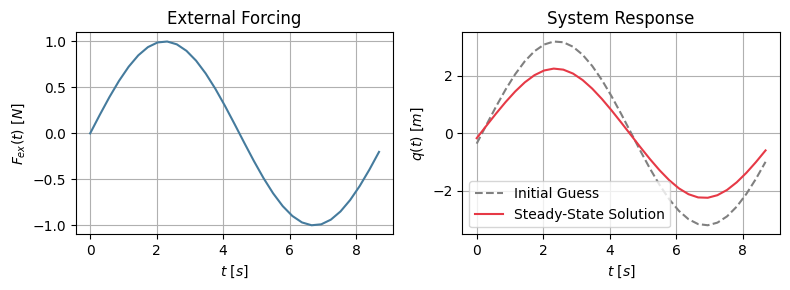

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve


# -------------------------------------------------------------------------------
# Conversion Helper Functions
# -------------------------------------------------------------------------------
def ce_to_time(ce):
    """Convert complex-exponential coefficients to time samples."""
    return np.real(np.fft.ifft(np.fft.ifftshift(ce)))


def time_to_ce(time):
    """Convert time samples to complex-exponential coefficients."""
    return np.fft.fftshift(np.fft.fft(time))


def cs_to_ce(cs):
    """Convert cosine-sine form to complex-exponential form."""
    ce = np.zeros(2*H+1, dtype=complex)
    ce[H] = cs[0]
    for k in range(1, H+1):
        ce[H + k] = (cs[1 + 2*(k-1)] - 1j * cs[1 + 2*(k-1) + 1]) / 2
        ce[H - k] = np.conj((cs[1 + 2*(k-1)] - 1j * cs[1 + 2*(k-1) + 1]) / 2)
    return ce


def ce_to_cs(ce):
    """Convert complex-exponential form to cosine-sine form."""
    ab = np.column_stack((2 * np.real(ce[H+1:]), -2 * np.imag(ce[H+1:]))).ravel()
    return np.concatenate(([ce[H].real], ab))


def reconstruct_time_signal(q_cs):
    """Reconstruct time signal from cosine-sine coefficients."""
    q_t = q_cs[0] * np.ones_like(t_phys)
    for k in range(1, H+1):
        a = q_cs[1 + 2*(k-1)]
        b = q_cs[1 + 2*(k-1) + 1]
        q_t += a * np.cos(k * Omega * t_phys) + b * np.sin(k * Omega * t_phys)
    return q_t


# -------------------------------------------------------------------------------
# Alternating Frequency-Time (AFT) Method
# -------------------------------------------------------------------------------
def aft(q_ce):
    q_t = ce_to_time(q_ce)      # iFFT
    fnl_t = alpha * q_t**3      # Nonlinear force in time domain
    fnl_ce = time_to_ce(fnl_t)  # FFT
    return fnl_ce


# -------------------------------------------------------------------------------
# Residual
# -------------------------------------------------------------------------------
def residual(q_cs):
    # Convert displacement to complex-exponential for residual computation
    q_ce = cs_to_ce(q_cs)
    # External force in complex-exponential form
    Fex_ce = np.zeros(2*H+1, dtype=complex)
    Fex_ce[H + 1] = -1j * F_0 / 2
    Fex_ce[H - 1] = +1j * F_0 / 2
    # Nonlinear force via AFT
    Fnl_ce = aft(q_ce)
    # Linear operator
    omega_k = np.arange(-H, H+1) * Omega  # harmonic frequencies
    S_diag = -m * (omega_k**2) + 1j * d * omega_k + c
    # Residual in complex-exponential form
    R_ce = S_diag * q_ce + Fnl_ce - Fex_ce
    # Convert residual to cosine-sine form for fsolve
    R_cs = ce_to_cs(R_ce)
    return R_cs


# -------------------------------------------------------------------------------
# Harmonic Balance Workflow
# -------------------------------------------------------------------------------
# System parameters
m = 1.0         # Mass
d = 0.05        # Damping coefficient
c = 0.8         # Linear spring stiffness
alpha = 1.8     # Rubber band stiffness
F_0 = 1.0       # External force amplitude
Omega = 0.7     # External force frequency
H = 3           # Number of harmonics
N = 10*H + 1    # Samples in time domain

# Physical time over one period
t_phys = np.arange(N) / N * (2*np.pi / Omega)

# Initial guess in cosine-sine form for solver
q_cs_0 = np.zeros(2*H+1)
q_1 = (-1j * F_0/2) / (c - m * Omega**2 + 1j * d * Omega)
q_cs_0[1] = 2 * q_1.real
q_cs_0[2] = -2 * q_1.imag

# Pseudo-Newton method for iterative solution process
q_cs = fsolve(residual, q_cs_0)

# Time signals reconstruction
Fex_t = F_0 * np.sin(Omega * t_phys)
q_t_0 = reconstruct_time_signal(q_cs_0)
q_t = reconstruct_time_signal(q_cs)

# Result plots
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(t_phys, Fex_t, color='#457B9D')
axs[0].set_xlabel(r'$t\ [s]$'); axs[0].set_ylabel(r'$F_{ex}(t)\ [N]$')
axs[0].grid(True)
axs[0].set_title('External Forcing')
axs[1].plot(t_phys, q_t_0, color='gray', linestyle='--', label='Initial Guess')
axs[1].plot(t_phys, q_t, color='#E63946', label='Steady-State Solution')
axs[1].set_xlabel(r'$t\ [s]$'); axs[1].set_ylabel(r'$q(t)\ [m]$')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('System Response')
plt.tight_layout()
plt.show()